In [1]:
# Step 1 run this

#Basic libraries
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Machine Learning libraries
import sklearn
from sklearn.model_selection import train_test_split

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

## Importing the dataset
Let's welcome our dataset and see what's inside the box

In [3]:
# Step 2 run this

#reading the fake and true datasets
fake_news = pd.read_csv('Fake.csv')
true_news = pd.read_csv('True.csv')

# print shape of fake dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())

print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None
The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [4]:
# Step 3 run this
#Target variable for fake news
fake_news['output']=0

#Target variable for true news
true_news['output']=1

In [5]:
# Step 4 run this
#Concatenating and dropping for fake news
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

In [6]:
# Step 5 run this
fake_news['date'].value_counts()

May 10, 2017         46
May 26, 2016         44
May 6, 2016          44
May 5, 2016          44
May 11, 2016         43
                     ..
December 9, 2017      1
December 4, 2017      1
November 19, 2017     1
November 20, 2017     1
Jul 19, 2015          1
Name: date, Length: 1681, dtype: int64

If you notice, we had links and news headline inside the date column which can give us trouble when converting to datetime format. So let's remove those records from the column

In [7]:
# Step 6 run this
#Removing links and the headline from the date column
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

Only fake news dataset had an issue with date column,Now let's proceed with converting the date column to datetime format

In [8]:
# Step 7 run this
#Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

## Appending two datasets
When we are providing a dataset for the model, we have to provide it as a single file. So it's better to append both true and fake news data and preprocess it further and perform EDA

In [9]:
# Step 8 run this
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
21412,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...,1
21413,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...,1
21414,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...,1
21415,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...,1


## Text Processing


In [10]:
# Step 9 run this
#Creating a copy
clean_news=news_dataset.copy()

In [11]:
# Step 10 run this
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
# Step 11 run this
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0
4,News,2017-12-25,pope francis just called out donald trump dur...,0


We have removed all punctuation in our news column

## News-Stop words


In [13]:
# Step 12 run this
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# Step 13 run this
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends embarrassing new year’s eve...,0
1,News,2017-12-31,drunk bragging trump staffer started russian c...,0
2,News,2017-12-30,sheriff david clarke becomes internet joke thr...,0
3,News,2017-12-29,trump obsessed even obama’s name coded website...,0
4,News,2017-12-25,pope francis called donald trump christmas spe...,0


We have removed all the stop words in the review column

<a id="section-three"></a>
#Visualization from news


## Count of news subject


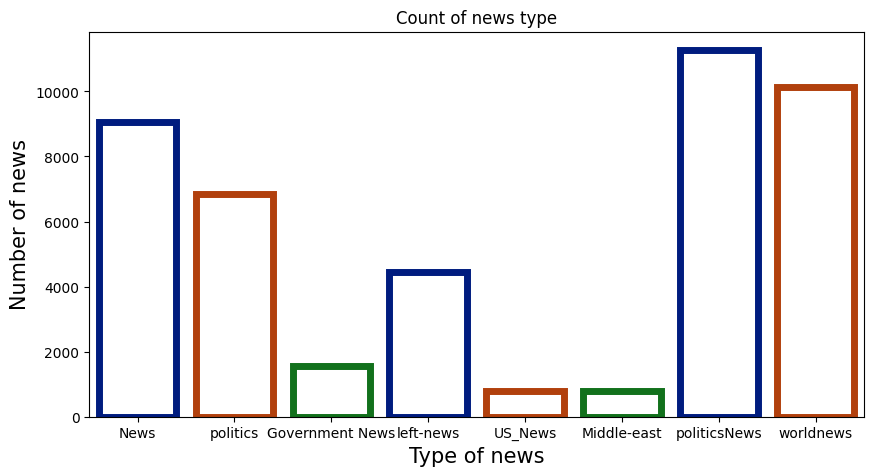

In [15]:
#Plotting the frequency plot
ax = sns.countplot(x="subject", data=clean_news,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

**Insights:**
* Our dataset has more political news than any other news followed by world news


## Count of news subject based on true or fake
Lets look at the count based on the fake/true outcome.

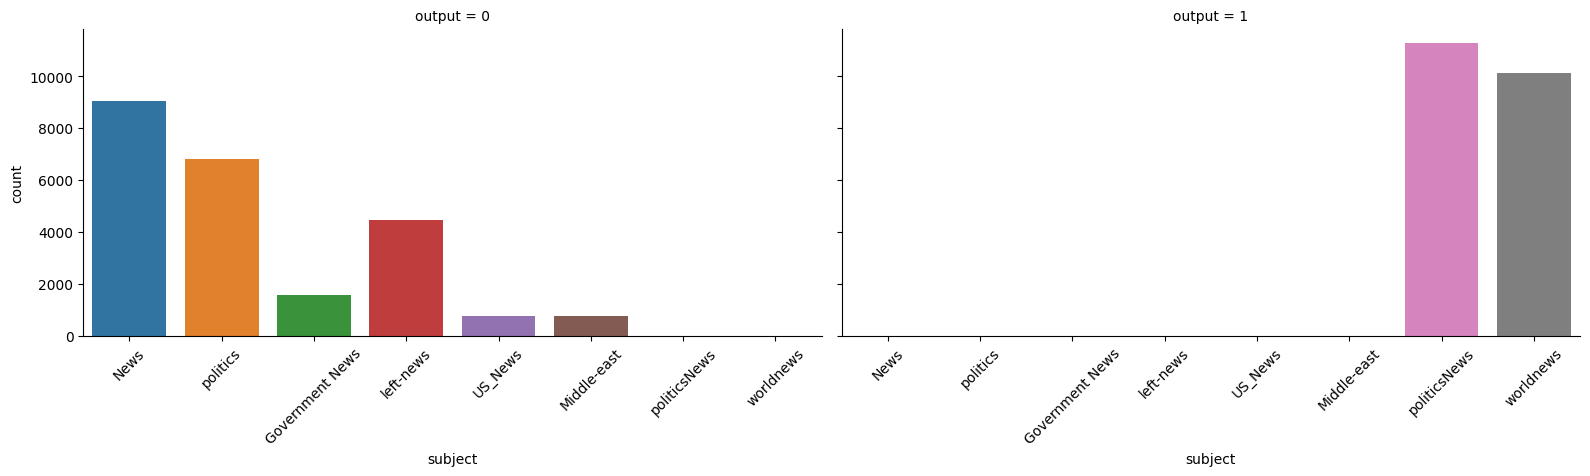

In [16]:
g = sns.catplot(x="subject", col="output",
                data=clean_news, kind="count",
                height=4, aspect=2)

#Rotating the xlabels
g.set_xticklabels(rotation=45)

**Insights:**

* True news are present only in politics and world news and the count is high


## Count of fake news and true news
Let's check the count of fake and true news and confirm whether our data is balanced or not

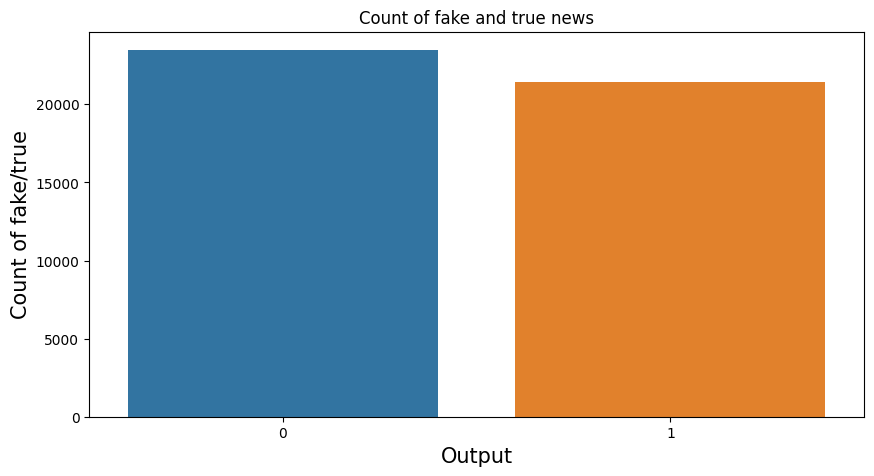

In [17]:
ax=sns.countplot(x="output", data=clean_news)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

**Insights:**
* We have a pretty much balanced data
* But the count of fake news is higher than the true news but not on a greater extent

## N-gram analysis

### Top 20 words in News
Let's look at the top 20 words from the news which could give us a brief idea on what news are popular in our dataset

In [18]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')


trump 140400
said 130258
us 68081
would 55422
president 53189
people 41718
one 36146
state 33190
new 31799
also 31209
obama 29881
clinton 29003
house 28716
government 27392
donald 27376
reuters 27348
states 26331
republican 25287
could 24356
white 23823


**Insights:**
* All the top 20 news are about the US government
* Especially it's about Trump and US followed by obama

### Top 2 words in the news
Now let's expand our search to top 2 words from the news

In [19]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_bigram(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')


donald trump 25059
united states 18394
white house 15485
hillary clinton 9502
new york 8110
north korea 7053
president donald 6928
image via 6188
barack obama 5603
trump said 4816
prime minister 4753
president trump 4646
supreme court 4595
last year 4560
last week 4512
said statement 4425
fox news 4074
president obama 4065
islamic state 4014
national security 3858


**Insights:**
* As feared, I think the model will be biased in it's results considering the amount of trump news
* We can see the north korea news as well, I think it will be about the dispute between US and NK


In [20]:
#Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_trigram(clean_news['news'], 20)

#Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

#Creating a dataframe with words and count
df6 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Grouping the words and plotting their frequencies
df6.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in news')


president donald trump 6808
president barack obama 3735
new york times 2034
donald trump realdonaldtrump 1790
reuters president donald 1476
black lives matter 1436
president united states 1096
white house said 1050
presidentelect donald trump 1043
new york city 1006
president vladimir putin 955
news century wire 951
national security adviser 898
affordable care act 868
director james comey 860
speaker paul ryan 851
fbi director james 778
state rex tillerson 775
secretary state rex 765
russian president vladimir 745


**Insights:**
* There is an important news which ruled the US media-'Black lives matter' post the demise of Floyd. We can see that news has been covered in our data. There were lot of fake news revolved around the death.
* Rest of the news are about US politics

## WordCloud of Fake and True News


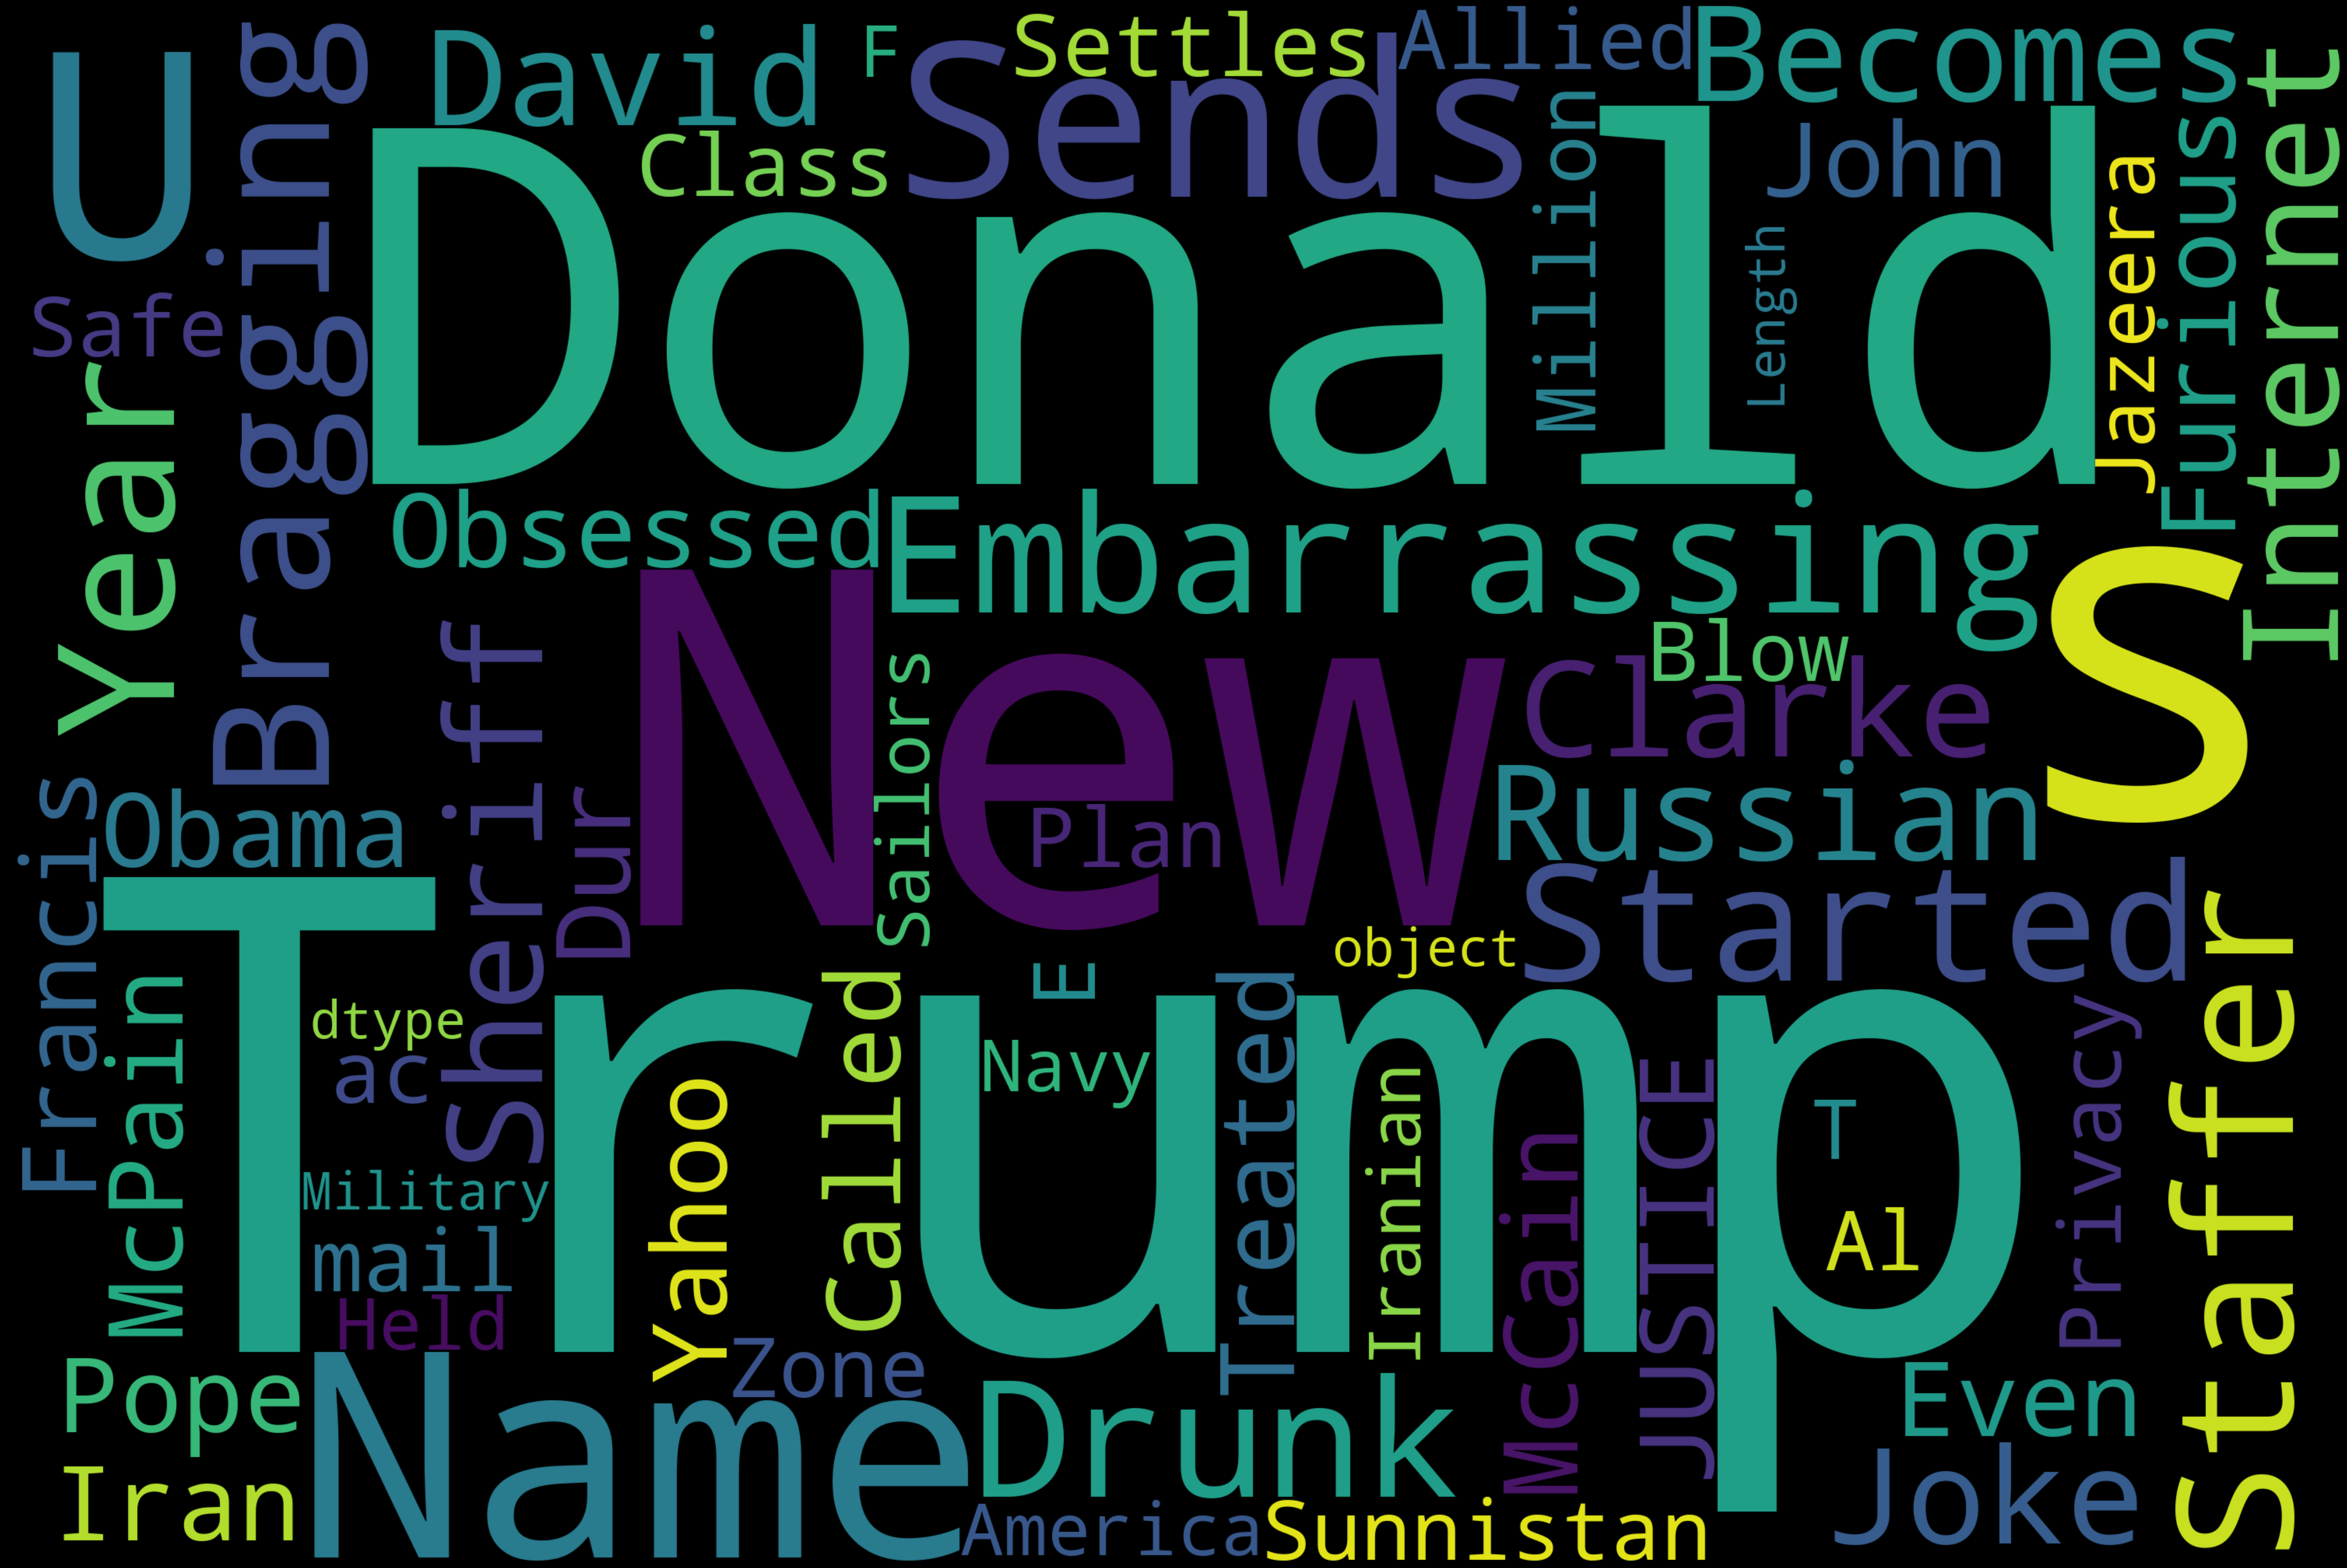

In [21]:
text = fake_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

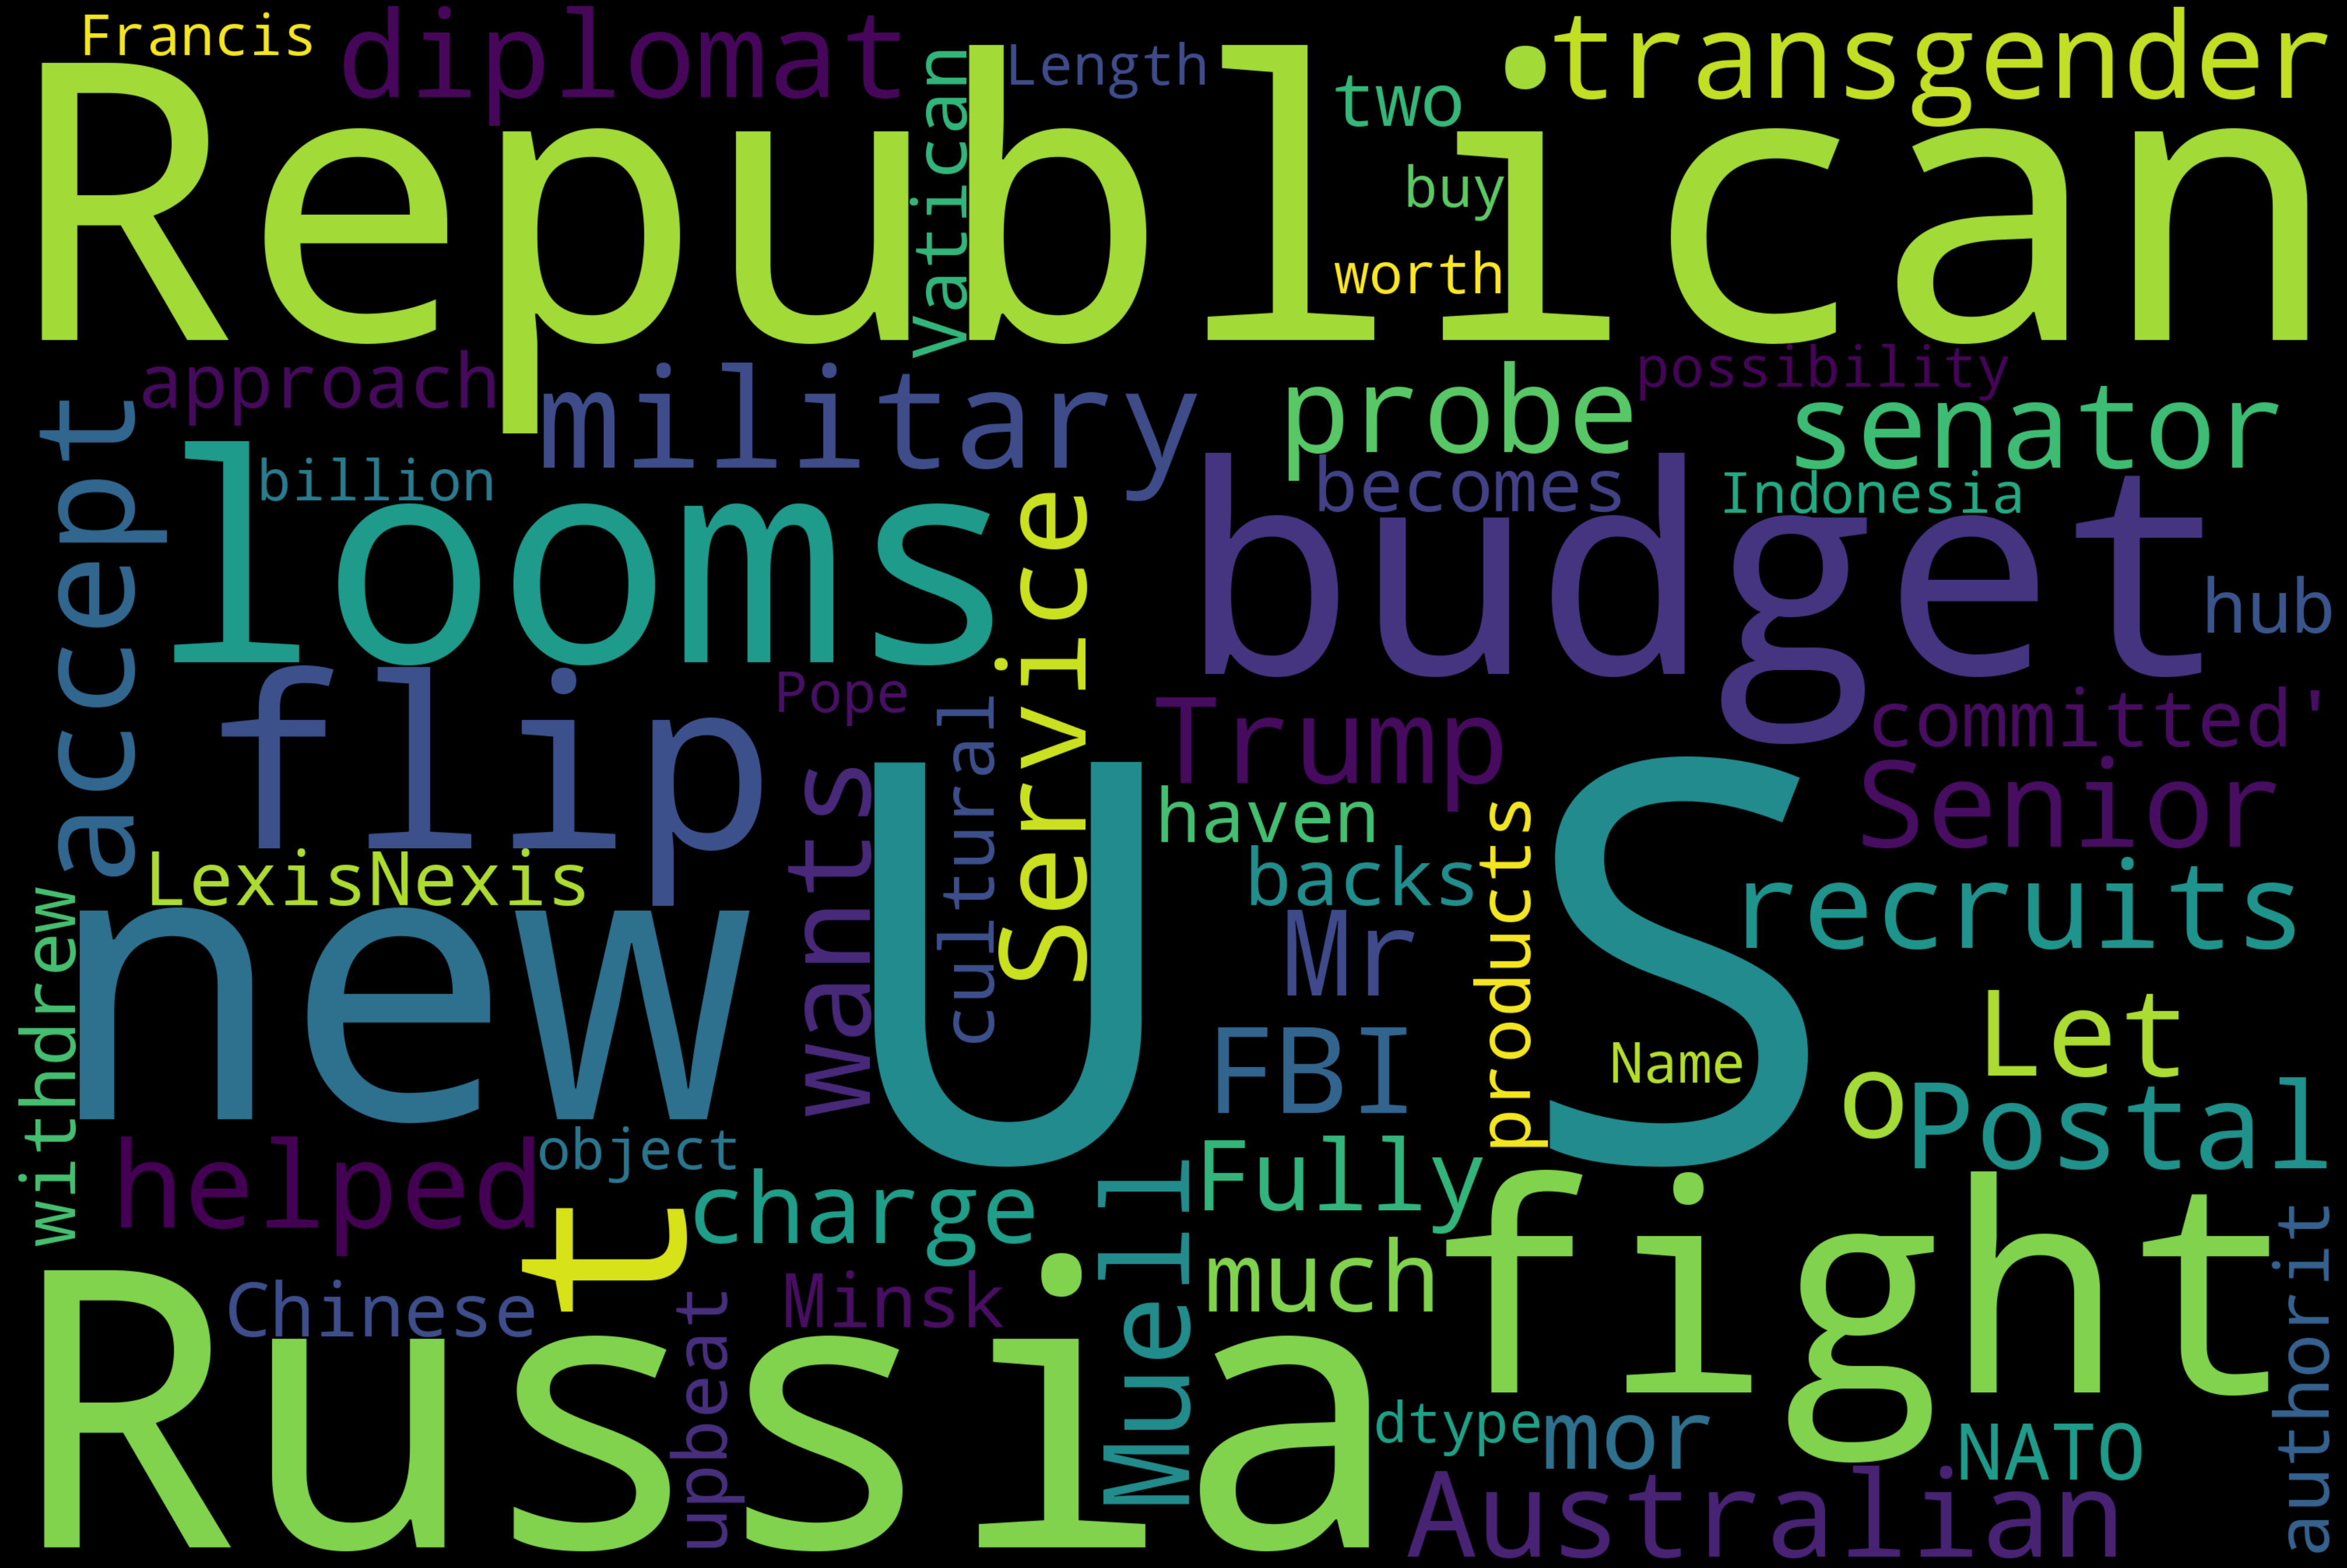

In [22]:
text = true_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<a id="section-four"></a>
# Stemming & Vectorizing



In [23]:
# Step 14 run this

news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,donald trump sends embarrassing new year’s eve...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama’s name coded website...
4,pope francis called donald trump christmas spe...


In [24]:
# Step 15 run this

stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)

In [25]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

## TFIDF(Term Frequency — Inverse Document Frequency)


In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(44888, 5000)

As we have considered 5000 words, we can confirm that we have 5000 columns from the shape.

In [27]:
#Getting the target variable
y=clean_news['output']

### Checking for balance of data


In [28]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({0: 23471, 1: 21417})


Our dataset is nearly a balanced one. So let's leave balancing it.

<a id="section-five"></a>
# Model Building

In [29]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

In [30]:
# Step 16 run this
#Setting up vocabulary size
voc_size=10000
#One hot encoding
onehot_repr=[one_hot(words,voc_size)for words in corpus]

We can see all the words in the sentences are transformed into their index from the vocabulary we created.

## Padding embedded documents

In [31]:
# Step 17 run this

#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 7460 1029 1277]
 [   0    0    0 ... 9693 5297 1277]
 [   0    0    0 ... 8177 8087 1277]
 ...
 [   0    0    0 ... 4439 1359 1921]
 [   0    0    0 ...  755 1965   76]
 [   0    0    0 ... 2395  261 6006]]


In [ ]:
embedded_docs[1]

array([   0,    0,    0, ..., 2074, 7391, 5442], dtype=int32)

## Model Building


In [32]:
# Step 18 run this

#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          400000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 456501 (1.74 MB)
Trainable params: 456501 (1.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [33]:
len(embedded_docs),y.shape

(44888, (44888,))

## Fitting the LSTM Model
Before fitting to the model, let's consider the padded embedded object as X and y as y itself and convert them into an array.

In [34]:
# Step 19 run this

# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44888, 5000), (44888,))

In [35]:
# Step 20 run this

# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [36]:

# Train test split of the X and y final
# X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train[:2000],y_train[:2000],validation_data=(X_test[:500],y_test[:500]),epochs=10,batch_size=64)

Epoch 1/10
32/32 [==============================] - 347s 11s/step - loss: 0.6467 - accuracy: 0.6125 - val_loss: 0.6463 - val_accuracy: 0.7720
Epoch 2/10
32/32 [==============================] - 361s 11s/step - loss: 0.4603 - accuracy: 0.8635 - val_loss: 0.4753 - val_accuracy: 0.9080
Epoch 3/10
32/32 [==============================] - 364s 11s/step - loss: 0.2956 - accuracy: 0.9405 - val_loss: 0.2022 - val_accuracy: 0.9200
Epoch 4/10
32/32 [==============================] - 362s 11s/step - loss: 0.1171 - accuracy: 0.9595 - val_loss: 0.1520 - val_accuracy: 0.9480
Epoch 5/10
32/32 [==============================] - 361s 11s/step - loss: 0.0583 - accuracy: 0.9840 - val_loss: 0.1411 - val_accuracy: 0.9500
Epoch 6/10
32/32 [==============================] - 362s 11s/step - loss: 0.0291 - accuracy: 0.9950 - val_loss: 0.1548 - val_accuracy: 0.9360
Epoch 7/10
32/32 [==============================] - 362s 11s/step - loss: 0.0117 - accuracy: 0.9990 - val_loss: 0.2247 - val_accuracy: 0.9360
Epoch 

In [37]:
model.save('my_model.h5')

In [38]:
# Step 21 run this

model = tf.keras.models.load_model('my_model.h5')

I Have run model only on part of dataset Due to time crunch , so if you want to run on all dataset , please do it it will definelty increase accuracy ,


In [39]:
#model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

We have got an accuracy of around 96%. That's awesome !

Testing Of Model

In [40]:
corpus[43]

'trump admit knew flynn lie fbi ask comey drop investigationdonald trump realli taken staffer advis tweet former nation secur advis michael flynn former realiti show star implic fire gener flynn lie vice presid fbi trump tweet pled guilti lie shame action transit law noth hide fire gener flynn lie vice presid fbi pled guilti lie shame action transit law noth hide donald j trump realdonaldtrump decemb oh god admit obstruct justic former justic depart spokesman matthew miller tweet trump knew flynn lie fbi ask comey let go case oh god admit obstruct justic trump knew flynn lie fbi ask comey let go case matthew miller matthewamil decemb last februari thenwhit hous press secretari sean spicer said trump ask flynn resign posit erod trust legal issu rather trust issu said timeaft flynn left trump defend call disgrac former nation secur advis wonder man think treat unfairli media call fake media mani case trump said februari think realli sad thing treat badli flynn resign apolog give inaccur 

In [41]:
# Step 22 run this

#predict
#for prediction data please pick sentese from corpus asits preprocessed one
#else you need to do preprocessing again

sentence = corpus[43]

onehot_demo=[one_hot(sentence,voc_size)]
embedded_demo=pad_sequences(onehot_demo,padding='pre',maxlen=sent_length)
print(embedded_demo)
X_demo=np.array(embedded_demo)
output = model.predict(X_demo)
print(output)
if output[0][0]*100 > 0.5 :
  print("Its a Real News")
else:
  print("Its a Fake News")


[[   0    0    0 ... 7487 4971 1277]]
1/1 [==============================] - 1s 1s/step
[[0.0018874]]
Its a Fake News


In [43]:
# Step 23 run this

sentence = corpus[4]

onehot_demo=[one_hot(sentence,voc_size)]
embedded_demo=pad_sequences(onehot_demo,padding='pre',maxlen=sent_length)
print(embedded_demo)
X_demo=np.array(embedded_demo)
output = model.predict(X_demo)
print(output)
if output[0][0]*100 > 0.5 :
  print("Its a Real News")
else:
  print("Its a Fake News")

[[   0    0    0 ... 6524 1287 1277]]
1/1 [==============================] - 2s 2s/step
[[0.00223556]]
Its a Fake News
